<a href="https://colab.research.google.com/github/RH00000/Rice_LLM_Replicability_Project/blob/main/recalibration_for_trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, brier_score_loss
from matplotlib import pyplot as plt

In [2]:
#Upload CSV File
from google.colab import files
uploaded = files.upload()

Saving prompt_5_ensembling_trial_2.csv to prompt_5_ensembling_trial_2.csv


In [4]:
# Load and basic validation
df = pd.read_csv("prompt_5_ensembling_trial_2.csv")

# Ensure the binary ground truth exists
if "result_binary" not in df.columns:
    raise KeyError("Column 'result_binary' not found in CSV. Need a binary 0/1 ground truth column.")


In [8]:
# Drop rows with missing essential data
required_cols = [
    "sample_size_prob",
    "p_value_prob",
    "method_complexity_prob",
    "author_citation_prob",
    "subfield_prob",
    "replication_probability",
    "result_binary"
]
for c in required_cols:
    if c not in df.columns:
        raise KeyError(f"Required column '{c}' is missing.")

df = df.dropna(subset=required_cols).copy()

In [9]:
# Ensure result_binary is 0 or 1
df["result_binary"] = pd.to_numeric(df["result_binary"], errors="coerce")
df = df[df["result_binary"].isin([0, 1])]  # filter invalid entries

In [10]:
# Split data (stratified) for calibration
X = df[["replication_probability"]]
y = df["result_binary"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [14]:
# Baseline metrics
auc_before = roc_auc_score(y_test, X_test["replication_probability"])
brier_before = brier_score_loss(y_test, X_test["replication_probability"])
print(f"AUC of test set before calibration: {auc_before:.4f}")
print(f"Brier score of test set before calibration: {brier_before:.4f}")

AUC of test set before calibration: 0.8241
Brier score of test set before calibration: 0.1809


In [15]:
# Isotonic regression calibration
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(X_train["replication_probability"], y_train)
calibrated_iso = iso.transform(X_test["replication_probability"])
auc_iso = roc_auc_score(y_test, calibrated_iso)
brier_iso = brier_score_loss(y_test, calibrated_iso)
print(f"AUC of test set after isotonic calibration: {auc_iso:.4f}")
print(f"Brier score of test set after isotonic calibration: {brier_iso:.4f}")

AUC of test set after isotonic calibration: 0.7708
Brier score of test set after isotonic calibration: 0.1936


In [16]:
# Platt scaling (logistic regression on raw score)
platt = LogisticRegression(solver="liblinear")
platt.fit(X_train, y_train)
calibrated_platt = platt.predict_proba(X_test)[:, 1]
auc_platt = roc_auc_score(y_test, calibrated_platt)
brier_platt = brier_score_loss(y_test, calibrated_platt)
print(f"AUC of test set after Platt scaling: {auc_platt:.4f}")
print(f"Brier score of test set after Platt scaling: {brier_platt:.4f}")

AUC of test set after Platt scaling: 0.8241
Brier score of test set after Platt scaling: 0.2139


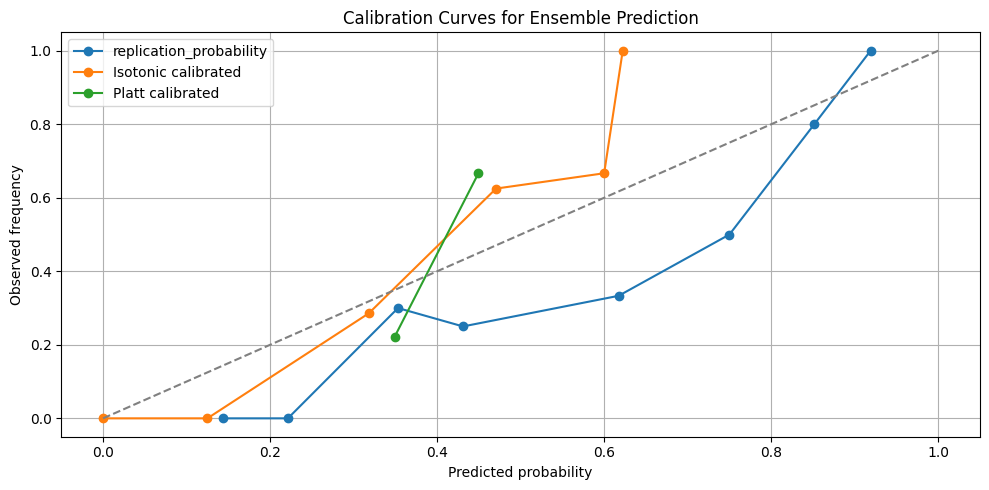

In [17]:
# Calibration curves
plt.figure(figsize=(10, 5))

# before
prob_true_raw, prob_pred_raw = calibration_curve(y_test, X_test["replication_probability"], n_bins=10, strategy="uniform")
plt.plot(prob_pred_raw, prob_true_raw, marker="o", label="replication_probability")

# Isotonic
prob_true_iso, prob_pred_iso = calibration_curve(y_test, calibrated_iso, n_bins=10, strategy="uniform")
plt.plot(prob_pred_iso, prob_true_iso, marker="o", label="Isotonic calibrated")

# Platt
prob_true_platt, prob_pred_platt = calibration_curve(y_test, calibrated_platt, n_bins=10, strategy="uniform")
plt.plot(prob_pred_platt, prob_true_platt, marker="o", label="Platt calibrated")

# Perfect calibration line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves for Ensemble Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()